# Testing local GPU vs. Colab GPUs performance using GAN MNIST generator with PyTorch

Model based on:  
https://www.tensorflow.org/tutorials/generative/dcgan

Pytorch implementation based on:  
https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f



In [0]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from time import time
from datetime import datetime
from IPython import display
import pandas as pd
import re
import os

In [0]:
# Settings and parameters

# Runtime settings
local_runtime = False    # local runtime with CUDA on Win10
use_gpu = False
gdrive_mounted = True

# Try to use CUDA only if available
gpu_selected_and_available = use_gpu & torch.cuda.is_available()

# Experiment parameters
batch_size = 256
learning_rate = 1e-4
num_epochs = 3
noise_dim = 100
num_examples_to_generate = 16

In [3]:
# Print backend info

print('Backend info:')

if local_runtime:
    if gpu_selected_and_available:
        !"C:\\Program Files\\NVIDIA Corporation\\NVSMI\\nvidia-smi.exe"
    else:
        !wmic cpu get caption, deviceid, name, numberofcores, maxclockspeed, status
else:
    if gpu_selected_and_available:
        !nvidia-smi
    else:
        !cat /proc/cpuinfo

Backend info:
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits phys

In [0]:
# Directory settings - restart runtime if runtime settings changed!

if not local_runtime:
    if gdrive_mounted:
        work_dir = '/content/drive/My Drive/GPU_tests/GAN_GPU_tests'
    else:
        work_dir = '/content/GAN_GPU_tests'
else:
    work_dir = 'C://OtherProjects//GPU_tests//GAN_GPU_tests'
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)

if gpu_selected_and_available:
    if local_runtime:
        device_name = !"C:\\Program Files\\NVIDIA Corporation\\NVSMI\\nvidia-smi.exe" --query-gpu=name --format=csv,noheader
        device_name = device_name[0]
    else:
        device_name = !nvidia-smi --query-gpu=name --format=csv,noheader
        device_name = device_name[0]
else:
    if local_runtime:
        device_name = 'Local_CPU'
    else:
        device_name = 'Colab_CPU'

data_path = os.path.join(os.getcwd(), 'data')
save_dir = os.path.join(os.getcwd(), 'results',
                        re.sub(' ', '_', device_name) + '_' +\
                        re.sub('-| |:', '', str(datetime.now()).split('.')[0]))
os.makedirs(save_dir, exist_ok=True)

In [0]:
# Prepare training set

trs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.MNIST(root=data_path, train=True,
                           transform=trs, download=True)

In [0]:
# Prepare data loader

data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True)

In [0]:
# Calcuate number of batches (iterations)

num_batches = len(data_loader)

In [0]:
# Discriminator class definition

class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.3)
        )

        self.linear = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(6272, 1)
        )

    def forward(self, x):
        BS = x.shape[0]
        x = self.conv(x)
        x = x.view(BS, -1)
        x = self.linear(x)
        return x

In [9]:
# Discriminator test

discriminator = Discriminator()
sample_tensor = torch.rand(batch_size, 1, 28, 28)

if gpu_selected_and_available:
    discriminator.cuda()
    sample_tensor = sample_tensor.cuda()

print(f'Model on CUDA: {next(discriminator.parameters()).is_cuda}\
        Input on CUDA: {sample_tensor.is_cuda}\
        Output shape: {discriminator.forward(sample_tensor).shape}')

Model on CUDA: False        Input on CUDA: False        Output shape: torch.Size([256, 1])


In [0]:
# Generator class definition

class Generator(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(100, 7*7*256, bias=False)
        )        

        self.tconv = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(256, 128, 5, stride=1,
                               padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(128, 64, 5, stride=2,
                               padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(64, 1, 5, stride=2,
                               padding=2, output_padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        BS = x.shape[0]
        x = self.linear(x)
        x = x.view(BS, 256, 7, 7)
        x = self.tconv(x)
        return x

Model on CUDA: False        Input on CUDA: False        Output shape: torch.Size([256, 1, 28, 28])
Sample generated image:


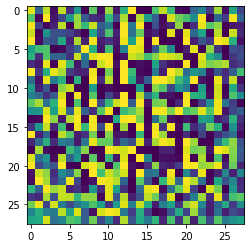

In [11]:
# Generator test

generator = Generator()
sample_noise = torch.rand(batch_size, 100)

if gpu_selected_and_available:
    generator.cuda()
    sample_noise = sample_noise.cuda()

generated_images = generator.forward(sample_noise)

print(f'Model on CUDA: {next(generator.parameters()).is_cuda}\
        Input on CUDA: {sample_noise.is_cuda}\
        Output shape: {generated_images.shape}')

if gpu_selected_and_available:
    generated_images = generated_images.cpu()

print('Sample generated image:')
plt.imshow(generated_images[0, 0, :, :].detach().numpy())

In [0]:
# Auxiliary functions

def noise(size, on_cuda=False):
    n = torch.randn(size, 100)
    if on_cuda:
        n = n.cuda()
    return n

def ones_target(size, on_cuda=False):
    data = torch.ones(size, 1)
    if on_cuda:
        data = data.cuda()
    return data

def zeros_target(size, on_cuda=False):
    data = torch.zeros(size, 1)
    if on_cuda:
        data = data.cuda()
    return data

def generate_and_save_images(save_dir, model, epoch, test_input, on_cuda=False):
    model.train(False)
    predictions = model.forward(test_input)
    if on_cuda:
        predictions = predictions.cpu()
    predictions = predictions.detach().numpy()
    model.train(True)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, 0, :, :]*127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(os.path.join(save_dir, f'image_at_epoch_{epoch}.png'))
    plt.show()

In [0]:
# Create discriminator and generator

discriminator = Discriminator()
generator = Generator()
if gpu_selected_and_available:
    discriminator.cuda()
    generator.cuda()    

In [0]:
# Set optimizer and loss function

discriminator_optimizer = optim.Adam(discriminator.parameters(),
                                     lr=learning_rate)
generator_optimizer = optim.Adam(generator.parameters(),
                                 lr=learning_rate)
loss = nn.BCEWithLogitsLoss()

In [0]:
# Function for discriminator training step

def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)

    # Reset gradients
    optimizer.zero_grad()

    ### Train on Real Data
    prediction_real = discriminator(real_data)

    # Calculate loss and backpropagate
    loss_real = loss(prediction_real,
                     ones_target(N, on_cuda=gpu_selected_and_available))
    loss_real.backward()

    ### Train on Fake Data
    prediction_fake = discriminator(fake_data)
    
    # Calculate loss and backpropagate
    loss_fake = loss(prediction_fake,
                     zeros_target(N, on_cuda=gpu_selected_and_available))
    loss_fake.backward()
    
    ### Update weights with gradients
    optimizer.step()
    
    # Return loss and predictions for real and fake inputs
    return loss_real + loss_fake, prediction_real, prediction_fake

In [0]:
# Function for generator training step

def train_generator(optimizer, fake_data):
    N = fake_data.size(0)

    # Reset gradients
    optimizer.zero_grad()

    # Sample noise and generate fake data
    prediction = discriminator(fake_data)

    # Calculate loss and backpropagate
    gen_loss = loss(prediction,
                    ones_target(N, on_cuda=gpu_selected_and_available))
    gen_loss.backward()

    # Update weights with gradients
    optimizer.step()
    
    # Return loss
    return gen_loss

In [0]:
# Generate test noise

test_noise = noise(num_examples_to_generate,
                   on_cuda=gpu_selected_and_available)

In [18]:
# Training loop

epoch_times = []
epoch_disc_losses = []
epoch_gen_losses = []

for epoch in range(num_epochs):
    
    t0 = time()
    running_disc_loss = 0.0
    running_gen_loss = 0.0
    
    for n_batch, (real_batch, _) in enumerate(data_loader):
        N = real_batch.size(0)
        if gpu_selected_and_available:
            real_batch = real_batch.cuda()

        ### Train Discriminator
        real_data = real_batch
        # Generate fake data and detach 
        fake_data = generator(noise(N, on_cuda=gpu_selected_and_available))
        # Train Disctriminator
        disc_loss, d_pred_real, d_pred_fake = \
              train_discriminator(discriminator_optimizer, real_data, fake_data)

        ### Train Generator
        # Generate fake data
        fake_data = generator(noise(N, on_cuda=gpu_selected_and_available))
        # Train Generator
        gen_loss = train_generator(generator_optimizer, fake_data)
        
        # Record batch losses
        if gpu_selected_and_available:
            disc_loss = disc_loss.cpu()
            gen_loss = gen_loss.cpu()
        running_disc_loss += disc_loss.item()
        running_gen_loss += gen_loss.item()

    # Record epoch time and losses
    epoch_times.append(time() - t0)
    epoch_disc_loss = running_disc_loss / num_batches
    epoch_gen_loss = running_gen_loss / num_batches
    epoch_disc_losses.append(epoch_disc_loss)
    epoch_gen_losses.append(epoch_gen_loss)

    # Display generated images after each epoch
    display.clear_output(wait=True)
    generate_and_save_images(save_dir, generator, epoch + 1, test_noise,
                             on_cuda=gpu_selected_and_available)

    # Print epoch time and losses
    print(f'Epoch: {epoch + 1}\
            Epoch time: {epoch_times[-1]}\
            Discriminator loss: {epoch_disc_loss}\
            Generator loss: {epoch_gen_loss}')
    
display.clear_output(wait=True)
print(f'Training complete. Total time in secs: {sum(epoch_times):.2f}')

Training complete. Total time in secs: 4282.32


Sample of generated images after last epoch:


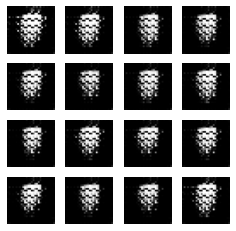

In [19]:
# Display and save generated images after last epoch
print('Sample of generated images after last epoch:')
generate_and_save_images(save_dir, generator, num_epochs, test_noise,
                         on_cuda=gpu_selected_and_available)

In [20]:
# Print and save time per epoch and gen/disc losses
stats_df = pd.DataFrame({'Epoch': list(range(1, num_epochs + 1)),
                         'Epoch_time': epoch_times,
                         'Discriminator_loss': epoch_disc_losses,
                         'Generator_loss': epoch_gen_losses})
stats_df.to_csv(os.path.join(save_dir, 'stats.csv'), index=False)
stats_df

,Epoch,Epoch_time,Discriminator_loss,Generator_loss
0,1,1436.215465,0.328619,2.473124
1,2,1454.837382,0.908438,1.680477
2,3,1391.265026,0.945617,1.707285


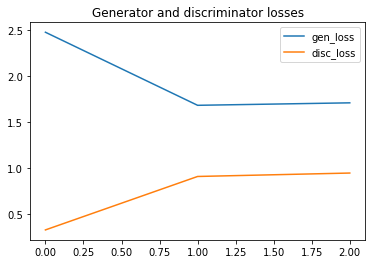

In [21]:
# Print and save epoch losses plot
plt.plot(epoch_gen_losses)
plt.plot(epoch_disc_losses)
plt.title('Generator and discriminator losses')
plt.legend(['gen_loss', 'disc_loss'])
plt.savefig(os.path.join(save_dir, 'epoch_losses.png'))

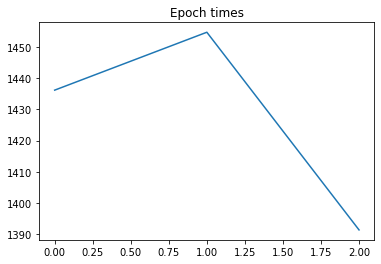

In [22]:
# Print and save epoch times plot
plt.plot(epoch_times)
plt.title('Epoch times')
plt.savefig(os.path.join(save_dir, 'epoch_times.png'))